In [124]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
import dask.bag as db

import json

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [125]:
# Use dask to read in the csv file as a dataframe
listings_df = dd.read_csv("Resources/listings.csv", assume_missing = True)

In [126]:
# Select only the columns we want for our analysis
listings_df = listings_df[["id", "neighbourhood", "latitude", "longitude", "room_type", "price", "availability_365", "calculated_host_listings_count"]].copy()
listings_df.head()

,id,neighbourhood,latitude,longitude,room_type,price,availability_365,calculated_host_listings_count
0,360.0,Highland,39.766415,-105.002098,Entire home/apt,91.0,179.0,2.0
1,364.0,Five Points,39.766720,-104.979060,Entire home/apt,179.0,358.0,1.0
2,590.0,North Park Hill,39.755110,-104.911090,Private room,59.0,146.0,2.0
3,592.0,North Park Hill,39.754810,-104.911060,Private room,58.0,210.0,2.0
4,1940.0,Baker,39.720205,-104.997499,Entire home/apt,77.0,243.0,1.0


In [127]:
# Find datatypes for each column
print(listings_df.dtypes)

id                                        float64
neighbourhood                     string[pyarrow]
latitude                                  float64
longitude                                 float64
room_type                         string[pyarrow]
price                                     float64
availability_365                          float64
calculated_host_listings_count            float64
dtype: object


In [128]:
# Change datatypes
listings_df["id"] = listings_df["id"].astype(int)
listings_df["availability_365"] = listings_df["availability_365"].astype(int)
listings_df["calculated_host_listings_count"] = listings_df["calculated_host_listings_count"].astype(int)

# Rename columns
listings_df = listings_df.rename(columns={
    "id": "ID",
    "neighbourhood": "Neighborhood",
    "latitude": "Latitude",
    "longitude": "Longitude",
    "room_type": "Listing Type",
    "price": "Price",
    "availability_365": "Available Days per Year",
    "calculated_host_listings_count": "Host Listings Count"
})

In [129]:
# Check datatypes were successfully changed
print(listings_df.dtypes)

ID                                   int64
Neighborhood               string[pyarrow]
Latitude                           float64
Longitude                          float64
Listing Type               string[pyarrow]
Price                              float64
Available Days per Year              int64
Host Listings Count                  int64
dtype: object


In [130]:
# Find out if there are null values in each column
print(listings_df.isnull().sum().compute())

ID                           0
Neighborhood                 0
Latitude                     0
Longitude                    0
Listing Type                 0
Price                      573
Available Days per Year      0
Host Listings Count          0
dtype: int64


In [131]:
# Remove all rows with null values
listings_df = listings_df.dropna()

In [132]:
# Recheck for null values
print(listings_df.isnull().sum().compute())

ID                         0
Neighborhood               0
Latitude                   0
Longitude                  0
Listing Type               0
Price                      0
Available Days per Year    0
Host Listings Count        0
dtype: int64


In [133]:
# Get statistical information
summary_stats = listings_df[["Latitude", "Longitude", "Price", "Available Days per Year"]].describe()
print(summary_stats.compute())

          Latitude    Longitude        Price  Available Days per Year
count  4578.000000  4578.000000  4578.000000              4578.000000
mean     39.742149  -104.975373   162.639144               219.004806
std       0.031772     0.061382   239.225490               116.491189
min      39.625750  -105.102804    10.000000                 0.000000
25%      39.728498  -105.016473    84.000000               116.000000
50%      39.748135  -104.984050   117.000000               237.000000
75%      39.762350  -104.957370   178.000000               334.000000
max      39.847417  -104.673817  9999.000000               365.000000


In [134]:
# Find out how many listings have "Available Days per Year" as 0
print(listings_df.query("`Available Days per Year` == 0").count().compute())

ID                         77
Neighborhood               77
Latitude                   77
Longitude                  77
Listing Type               77
Price                      77
Available Days per Year    77
Host Listings Count        77
dtype: int64


In [135]:
# Filter out all rows where "Available Days per Year" is 0
listings_df = listings_df.query("`Available Days per Year` ! = 0")

In [136]:
# Look at statistical information again after filtering out rows
summary_stats = listings_df[["Latitude", "Longitude", "Price", "Available Days per Year"]].describe()
print(summary_stats.compute())

          Latitude    Longitude        Price  Available Days per Year
count  4501.000000  4501.000000  4501.000000              4501.000000
mean     39.742191  -104.975155   162.798267               222.751389
std       0.031843     0.061594   240.860574               113.875617
min      39.625750  -105.102804    10.000000                 1.000000
25%      39.728490  -105.016480    84.000000               121.000000
50%      39.748120  -104.983920   116.000000               240.000000
75%      39.762540  -104.956978   178.000000               335.000000
max      39.847417  -104.673817  9999.000000               365.000000


In [137]:
listings_df_cleaned = listings_df.copy()
listings_df_cleaned.head()

,ID,Neighborhood,Latitude,Longitude,Listing Type,Price,Available Days per Year,Host Listings Count
0,360,Highland,39.766415,-105.002098,Entire home/apt,91.0,179,2
1,364,Five Points,39.766720,-104.979060,Entire home/apt,179.0,358,1
2,590,North Park Hill,39.755110,-104.911090,Private room,59.0,146,2
3,592,North Park Hill,39.754810,-104.911060,Private room,58.0,210,2
4,1940,Baker,39.720205,-104.997499,Entire home/apt,77.0,243,1


In [138]:
# Export cleaned data to a new csv
listings_df_cleaned.to_csv('Resources/cleaned_listings.csv', index=False, single_file=True)

['/Users/angelinamurdock/Desktop/Classwork/Project-5_Group-3/Resources/cleaned_listings.csv']

In [140]:
# Convert cleaned_listings.csv into a .js file 
cleaned_listings = dd.read_csv('Resources/cleaned_listings.csv')

# Compute the DataFrame to Pandas (if the dataset fits into memory)
listings_pandas_df = cleaned_listings.compute()

# Rename the columns
listings_pandas_df = listings_pandas_df.rename(columns={
    'Listing Type': 'listing_type',
    'Available Days per Year': 'available_days_per_year',
    'Host Listings Count': 'host_listings_count'
})

# Convert to list of dictionaries (this is how the data will be represented in JavaScript)
data_as_dict = listings_pandas_df.to_dict(orient='records')

# Write the JavaScript data to a .js file
with open("Map/static/data/listings.js", "w") as js_file:
    js_file.write(f"const listingsData = {data_as_dict};\n")

# Part 1 Potential Airbnb Revenue by Neighborhood

In [ ]:
# Convert price and availability_365 to int
listings_df_cleaned["Price"] = pd.to_numeric(listings_df_cleaned["Price"], errors="coerce")
listings_df_cleaned["Available Days per Year"] = pd.to_numeric(listings_df_cleaned["Available Days per Year"], errors="coerce")
# Multiply price * available days per year
listings_df_cleaned["potential_revenue"] = listings_df_cleaned["Price"] * listings_df_cleaned["Available Days per Year"]
# If llisting is at 70% occupancy
listings_df_cleaned["potential_revenue_70"] = listings_df_cleaned["Price"] * listings_df_cleaned["Available Days per Year"] * 0.7
# If llisting is at 50% occupancy
listings_df_cleaned["potential_revenue_50"] = listings_df_cleaned["Price"] * listings_df_cleaned["Available Days per Year"] * 0.5

listings_df_cleaned.tail(10)

,ID,Neighborhood,Latitude,Longitude,Listing Type,Price,Available Days per Year,Host Listings Count,potential_revenue,potential_revenue_70,potential_revenue_50
5141,1316043123780779776,City Park West,39.740669,-104.962569,Entire home/apt,100.0,361,1,36100.0,25270.0,18050.0
5142,1316151084554573312,CBD,39.745747,-104.996919,Entire home/apt,72.0,58,6,4176.0,2923.2,2088.0
5143,1316458458958774272,Mar Lee,39.690373,-105.048316,Entire home/apt,105.0,162,1,17010.0,11907.0,8505.0
5144,1316991465817433344,Harvey Park,39.677410,-105.061400,Private room,32.0,336,2,10752.0,7526.4,5376.0
5145,1318170331542034432,Whittier,39.757074,-104.961131,Entire home/apt,79.0,362,1,28598.0,20018.6,14299.0
5146,1318212155497719296,Highland,39.759641,-105.018975,Entire home/apt,68.0,363,6,24684.0,17278.8,12342.0
5147,1318217127843446272,Highland,39.759419,-105.017339,Entire home/apt,73.0,363,6,26499.0,18549.3,13249.5
5148,1319797068135992320,DIA,39.816660,-104.768770,Private room,42.0,89,3,3738.0,2616.6,1869.0
5149,1321150655773858816,Chaffee Park,39.791560,-105.022030,Entire home/apt,139.0,364,1,50596.0,35417.2,25298.0
5150,1321853267349842944,Goldsmith,39.676280,-104.922490,Entire home/apt,27.0,89,2,2403.0,1682.1,1201.5


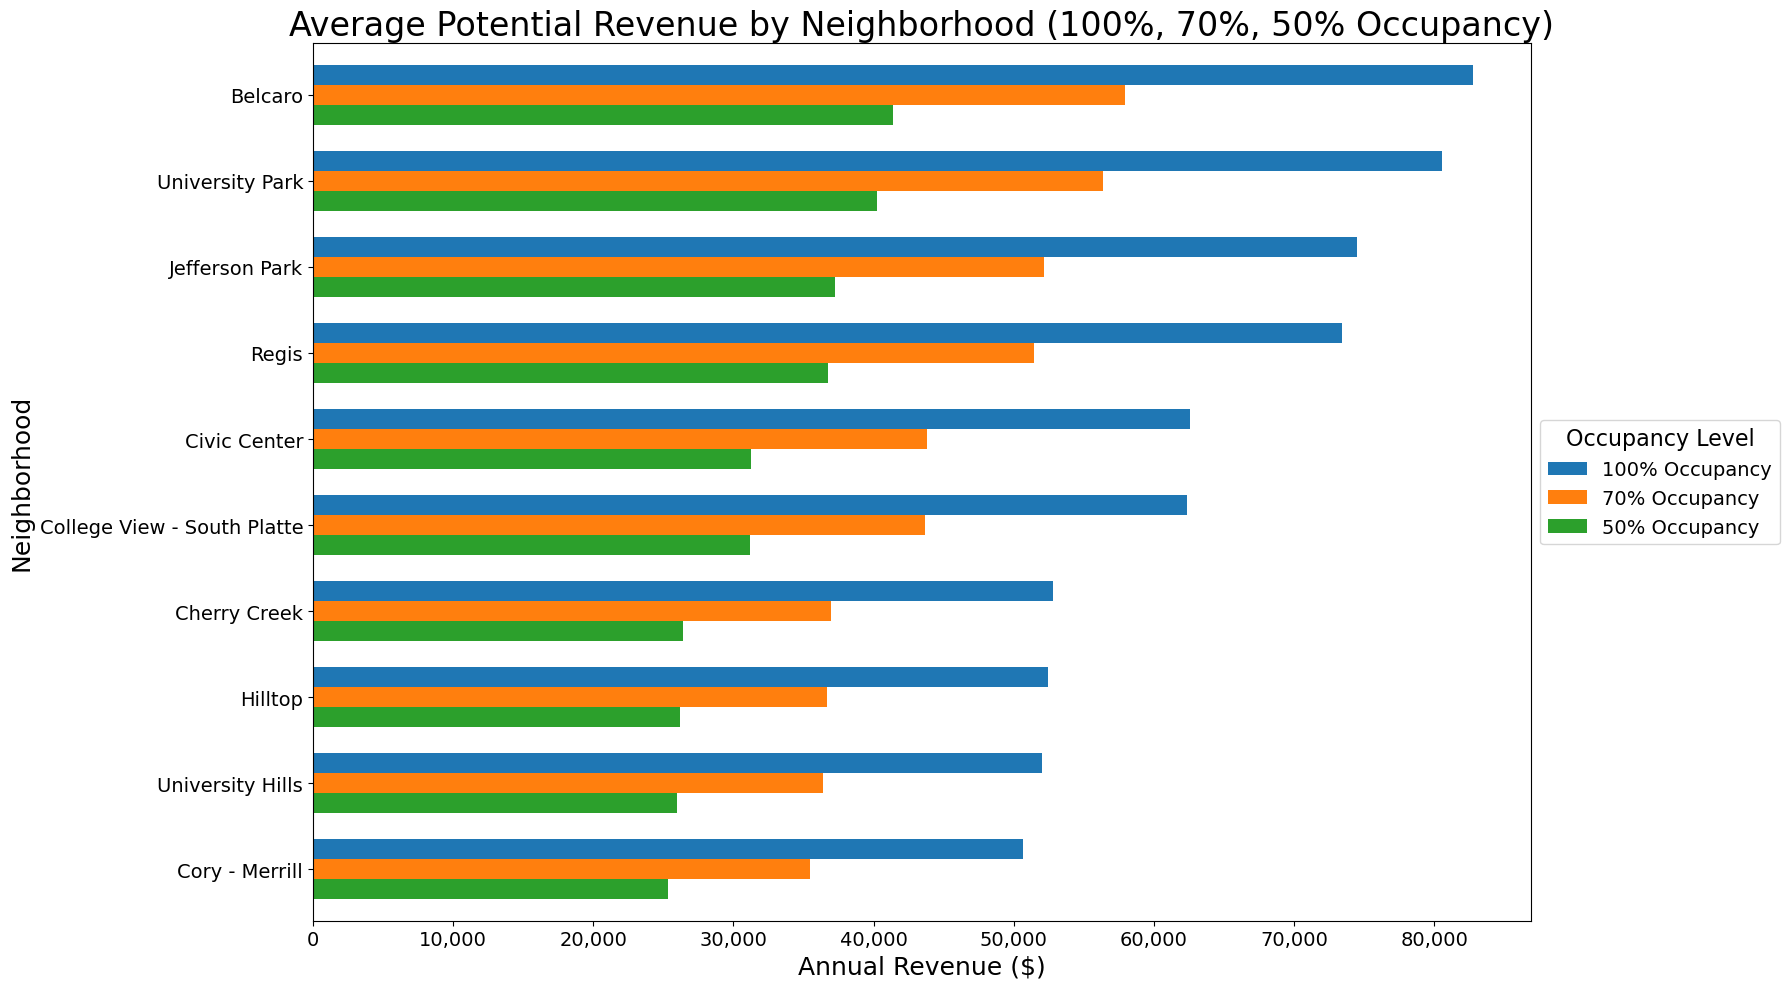

In [ ]:
# Convert from Dask
listings_df_cleaned_pd = listings_df_cleaned.compute()

# Group & sort
grouped = listings_df_cleaned_pd.groupby("Neighborhood")[["potential_revenue", "potential_revenue_70", "potential_revenue_50"]].mean()
grouped = grouped.sort_values("potential_revenue", ascending=False).head(10)

# Rename legend
grouped = grouped.rename(columns={
    "potential_revenue": "100% Occupancy",
    "potential_revenue_70": "70% Occupancy",
    "potential_revenue_50": "50% Occupancy"
})

# Plot
fig, ax = plt.subplots(figsize=(18, 10))
grouped.plot(kind='barh', width=0.7, ax=ax)

# Labels and formatting
ax.set_title("Average Potential Revenue by Neighborhood (100%, 70%, 50% Occupancy)", fontsize=24)
ax.set_xlabel("Annual Revenue ($)", fontsize=18)
ax.set_ylabel("Neighborhood", fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
plt.gca().invert_yaxis()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


# Legend outside chart
ax.legend(title="Occupancy Level", fontsize=14, title_fontsize=16, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.tight_layout()

plt.savefig('graphs/avg_potential_revenue_neighborhood.png')

plt.show()

# Part 2 real estate prices based on zillow

In [ ]:
# Use dask to read in  Neighborhood_zillow_real_estate_data.csv file as a dataframe
real_estate_neighborhood_df = dd.read_csv("Resources/Neighborhood_zillow_real_estate_data.csv", assume_missing = True)
real_estate_neighborhood_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,...,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28
0,112345.0,0.0,Maryvale,neighborhood,AZ,AZ,Phoenix,"Phoenix-Mesa-Chandler, AZ",Maricopa County,67583.518398,...,3.414316e+05,3.423949e+05,3.428074e+05,3.427356e+05,3.419887e+05,3.408405e+05,3.396659e+05,3.388768e+05,3.377961e+05,3.359831e+05
1,192689.0,1.0,Paradise,neighborhood,NV,NV,Las Vegas,"Las Vegas-Henderson-Paradise, NV",Clark County,131822.893122,...,3.811490e+05,3.835971e+05,3.857815e+05,3.874718e+05,3.887102e+05,3.896048e+05,3.907356e+05,3.922168e+05,3.934987e+05,3.939496e+05
2,270958.0,2.0,Upper West Side,neighborhood,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,381660.874369,...,1.169479e+06,1.169561e+06,1.173572e+06,1.182601e+06,1.187323e+06,1.191276e+06,1.203791e+06,1.222023e+06,1.237589e+06,1.245587e+06
3,270957.0,3.0,Upper East Side,neighborhood,NY,NY,New York,"New York-Newark-Jersey City, NY-NJ-PA",New York County,624209.066407,...,1.161944e+06,1.160380e+06,1.162163e+06,1.168415e+06,1.171441e+06,1.173235e+06,1.184594e+06,1.201830e+06,1.216919e+06,1.222750e+06
4,118208.0,4.0,South Los Angeles,neighborhood,CA,CA,Los Angeles,"Los Angeles-Long Beach-Anaheim, CA",Los Angeles County,130013.865244,...,6.633109e+05,6.635775e+05,6.661953e+05,6.714373e+05,6.780470e+05,6.834528e+05,6.871959e+05,6.899128e+05,6.883663e+05,6.834446e+05


In [ ]:
# Select only the columns we want for our analysis
real_estate_neighborhood_df = real_estate_neighborhood_df[["RegionID", "RegionName", "State", "City", "2024-01-31", "2024-02-29", "2024-03-31", "2024-04-30", "2024-05-31", "2024-06-30", "2024-07-31", "2024-08-31", "2024-09-30", "2024-10-31", "2024-11-30", "2024-12-31"]].copy()
real_estate_neighborhood_df.head()

,RegionID,RegionName,State,City,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
0,112345.0,Maryvale,AZ,Phoenix,3.357290e+05,3.367033e+05,3.381803e+05,3.400057e+05,3.414316e+05,3.423949e+05,3.428074e+05,3.427356e+05,3.419887e+05,3.408405e+05,3.396659e+05,3.388768e+05
1,192689.0,Paradise,NV,Las Vegas,3.725479e+05,3.743522e+05,3.761585e+05,3.785524e+05,3.811490e+05,3.835971e+05,3.857815e+05,3.874718e+05,3.887102e+05,3.896048e+05,3.907356e+05,3.922168e+05
2,270958.0,Upper West Side,NY,New York,1.185179e+06,1.179215e+06,1.173972e+06,1.171712e+06,1.169479e+06,1.169561e+06,1.173572e+06,1.182601e+06,1.187323e+06,1.191276e+06,1.203791e+06,1.222023e+06
3,270957.0,Upper East Side,NY,New York,1.176590e+06,1.170734e+06,1.166905e+06,1.164981e+06,1.161944e+06,1.160380e+06,1.162163e+06,1.168415e+06,1.171441e+06,1.173235e+06,1.184594e+06,1.201830e+06
4,118208.0,South Los Angeles,CA,Los Angeles,6.790626e+05,6.726087e+05,6.658937e+05,6.633438e+05,6.633109e+05,6.635775e+05,6.661953e+05,6.714373e+05,6.780470e+05,6.834528e+05,6.871959e+05,6.899128e+05


In [ ]:
# Pull only the data for Denver
denver_real_estate_neighborhood_df = real_estate_neighborhood_df.query("City == 'Denver'")
denver_real_estate_neighborhood_df.head()

,RegionID,RegionName,State,City,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
235,273809.0,Gateway - Green Valley Ranch,CO,Denver,491007.161995,491035.364888,491392.950975,491882.612105,491760.579762,490858.062361,489745.958237,488726.750030,487995.892604,487302.918410,486903.731696,486630.545212
329,6018.0,Montbello,CO,Denver,438542.958204,438864.819361,439648.745422,440609.850528,441051.882758,440704.584839,439855.248083,439006.425223,438219.703796,437274.333697,436726.770604,436244.288979
410,275564.0,Central Park,CO,Denver,811468.548208,808313.788628,807909.760277,809607.440587,810438.023097,808244.803889,805155.863258,802598.736735,801195.640708,799657.640124,798600.457230,798423.875011
602,268671.0,Hampden,CO,Denver,526324.587562,525805.315859,525939.414980,525984.010962,525244.032565,523673.717091,522134.523951,521460.718137,521413.062907,521744.191939,522074.783631,522563.712560
681,268662.0,Five Points,CO,Denver,620700.178593,619673.583635,619819.928185,620063.873246,618676.421526,615327.394116,611031.871498,607721.730126,605831.104045,604129.703444,603280.732065,603091.967420


In [ ]:
# Check for null values
print(denver_real_estate_neighborhood_df.isnull().sum().compute())

RegionID      0
RegionName    0
State         0
City          0
2024-01-31    0
2024-02-29    0
2024-03-31    0
2024-04-30    0
2024-05-31    0
2024-06-30    0
2024-07-31    0
2024-08-31    0
2024-09-30    0
2024-10-31    0
2024-11-30    0
2024-12-31    0
dtype: int64


In [ ]:
# Check datatypes
print(denver_real_estate_neighborhood_df.dtypes)

RegionID              float64
RegionName    string[pyarrow]
State         string[pyarrow]
City          string[pyarrow]
2024-01-31            float64
2024-02-29            float64
2024-03-31            float64
2024-04-30            float64
2024-05-31            float64
2024-06-30            float64
2024-07-31            float64
2024-08-31            float64
2024-09-30            float64
2024-10-31            float64
2024-11-30            float64
2024-12-31            float64
dtype: object


In [ ]:
# Change column names 
denver_real_estate_neighborhood_df = denver_real_estate_neighborhood_df.rename(columns={'RegionName': 'Neighborhood'})
denver_real_estate_neighborhood_df.head()

,RegionID,Neighborhood,State,City,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
235,273809.0,Gateway - Green Valley Ranch,CO,Denver,491007.161995,491035.364888,491392.950975,491882.612105,491760.579762,490858.062361,489745.958237,488726.750030,487995.892604,487302.918410,486903.731696,486630.545212
329,6018.0,Montbello,CO,Denver,438542.958204,438864.819361,439648.745422,440609.850528,441051.882758,440704.584839,439855.248083,439006.425223,438219.703796,437274.333697,436726.770604,436244.288979
410,275564.0,Central Park,CO,Denver,811468.548208,808313.788628,807909.760277,809607.440587,810438.023097,808244.803889,805155.863258,802598.736735,801195.640708,799657.640124,798600.457230,798423.875011
602,268671.0,Hampden,CO,Denver,526324.587562,525805.315859,525939.414980,525984.010962,525244.032565,523673.717091,522134.523951,521460.718137,521413.062907,521744.191939,522074.783631,522563.712560
681,268662.0,Five Points,CO,Denver,620700.178593,619673.583635,619819.928185,620063.873246,618676.421526,615327.394116,611031.871498,607721.730126,605831.104045,604129.703444,603280.732065,603091.967420


In [ ]:
# Find unique neighborhood names in real estate data
print(denver_real_estate_neighborhood_df['Neighborhood'].unique().compute())

0     Gateway - Green Valley Ranch
1                        Montbello
2                     Central Park
3                          Hampden
4                      Five Points
                  ...             
71                    Country Club
72                    Civic Center
73                        Rosedale
74    Denver International Airport
75                         Auraria
Name: Neighborhood, Length: 76, dtype: object


In [ ]:
# Find unique neighborhood names in listings data
print(listings_df_cleaned['Neighborhood'].unique().compute())

0               Highland
1            Five Points
2        North Park Hill
3                  Baker
4     North Capitol Hill
             ...        
72           Harvey Park
73              Westwood
74     Harvey Park South
75        Elyria Swansea
76               Kennedy
Name: Neighborhood, Length: 77, dtype: object


In [ ]:
# Find the average home price for each neighborhood in 2024 
# Example to get the average of 'Column1', 'Column2', and 'Column3' for each row
months_2024 = ['2024-01-31', '2024-02-29', '2024-03-31','2024-04-30', '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31', '2024-09-30', '2024-10-31', '2024-11-30', '2024-12-31']
denver_real_estate_neighborhood_df['Average Home Price 2024'] = real_estate_neighborhood_df[months_2024].mean(axis=1).round(2).compute()
denver_real_estate_neighborhood_df.head()

,RegionID,Neighborhood,State,City,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,Average Home Price 2024
235,273809.0,Gateway - Green Valley Ranch,CO,Denver,491007.161995,491035.364888,491392.950975,491882.612105,491760.579762,490858.062361,489745.958237,488726.750030,487995.892604,487302.918410,486903.731696,486630.545212,489603.54
329,6018.0,Montbello,CO,Denver,438542.958204,438864.819361,439648.745422,440609.850528,441051.882758,440704.584839,439855.248083,439006.425223,438219.703796,437274.333697,436726.770604,436244.288979,438895.80
410,275564.0,Central Park,CO,Denver,811468.548208,808313.788628,807909.760277,809607.440587,810438.023097,808244.803889,805155.863258,802598.736735,801195.640708,799657.640124,798600.457230,798423.875011,805134.55
602,268671.0,Hampden,CO,Denver,526324.587562,525805.315859,525939.414980,525984.010962,525244.032565,523673.717091,522134.523951,521460.718137,521413.062907,521744.191939,522074.783631,522563.712560,523696.84
681,268662.0,Five Points,CO,Denver,620700.178593,619673.583635,619819.928185,620063.873246,618676.421526,615327.394116,611031.871498,607721.730126,605831.104045,604129.703444,603280.732065,603091.967420,612445.71


In [ ]:
# Create a new dataframe without the monthly price data
cleaned_denver_real_estate_df = denver_real_estate_neighborhood_df[["RegionID", "Neighborhood", "State", "City", "Average Home Price 2024"]].copy()
cleaned_denver_real_estate_df.head()

,RegionID,Neighborhood,State,City,Average Home Price 2024
235,273809.0,Gateway - Green Valley Ranch,CO,Denver,489603.54
329,6018.0,Montbello,CO,Denver,438895.80
410,275564.0,Central Park,CO,Denver,805134.55
602,268671.0,Hampden,CO,Denver,523696.84
681,268662.0,Five Points,CO,Denver,612445.71


In [ ]:
# Export the cleaned dataframe to a csv file
cleaned_denver_real_estate_df.to_csv('Resources/cleaned_denver_real_estate.csv', index=False, single_file=True)

['/Users/angelinamurdock/Desktop/Classwork/Project-5_Group-3/Resources/cleaned_denver_real_estate.csv']

In [ ]:
# Use dask to read in the csv file as a dataframe
zillow_df = dd.read_csv("Resources/cleaned_denver_real_estate.csv", assume_missing = True)

In [ ]:
# Select only the columns we want for our analysis
zillow_df = zillow_df[["RegionID", "Neighborhood", "Average Home Price 2024"]].copy()
zillow_df.head()

,RegionID,Neighborhood,Average Home Price 2024
0,273809.0,Gateway - Green Valley Ranch,489603.54
1,6018.0,Montbello,438895.80
2,275564.0,Central Park,805134.55
3,268671.0,Hampden,523696.84
4,268662.0,Five Points,612445.71


In [ ]:
# Find datatypes for each column
print(zillow_df.dtypes)

RegionID                           float64
Neighborhood               string[pyarrow]
Average Home Price 2024            float64
dtype: object


In [ ]:
# Find out if there are null values in each column
print(zillow_df.isnull().sum().compute())

RegionID                   0
Neighborhood               0
Average Home Price 2024    0
dtype: int64


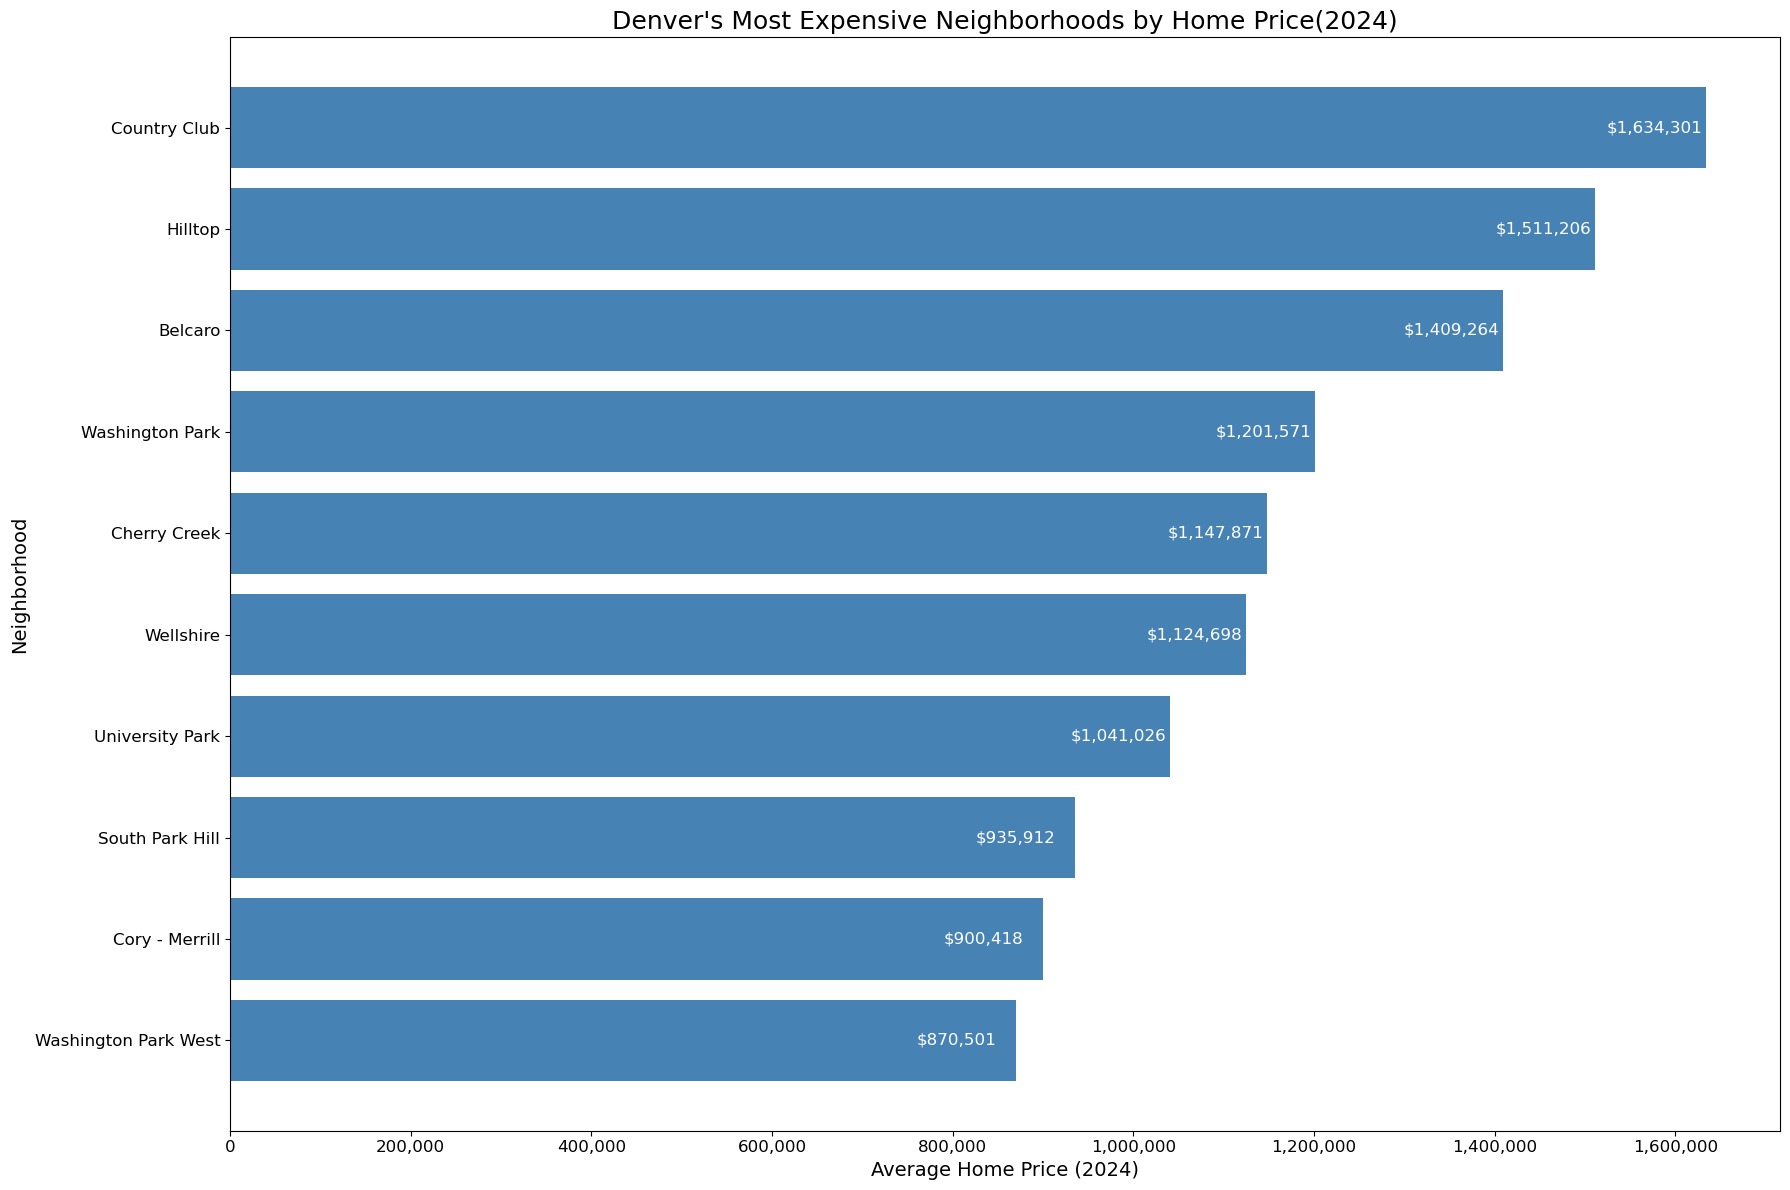

In [ ]:
# Convert from Dask
zillow_df_pd = zillow_df.compute()

# Sort by home price and pick top 20 for readability
zillow_sorted = zillow_df.sort_values("Average Home Price 2024", ascending=False).head(10)
                                                                                    
# Plot
plt.figure(figsize=(18, 12))
plt.barh(zillow_sorted["Neighborhood"], zillow_sorted["Average Home Price 2024"])
plt.xlabel("Average Home Price (2024)", fontsize=14)
plt.ylabel("Neighborhood", fontsize=14)
plt.title("Denver's Most Expensive Neighborhoods by Home Price(2024)", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()  # Highest price at top
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

# Add value labels
bars = ax.barh(zillow_sorted["Neighborhood"], zillow_sorted["Average Home Price 2024"], color="steelblue")
for bar in bars:
    width = bar.get_width()
    plt.text(width - 110000,                      # x-position ( right of the bar)
             bar.get_y() + bar.get_height() / 2, # y-position (middle of the bar)
             f"${width:,.0f}",                   # formatted value with dollar sign and commas
             va='center', fontsize=12, color="white")

plt.savefig('graphs/top_10_neighborhoods_price.png')
plt.show()

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/dask/dataframe/core.py:3769: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(
/opt/anaconda3/envs/dev/lib/python3.10/site-packages/dask/dataframe/core.py:3769: UserWarning: Dask currently has limited support for converting pandas extension dtypes to arrays. Converting string to object dtype.
  warnings.warn(


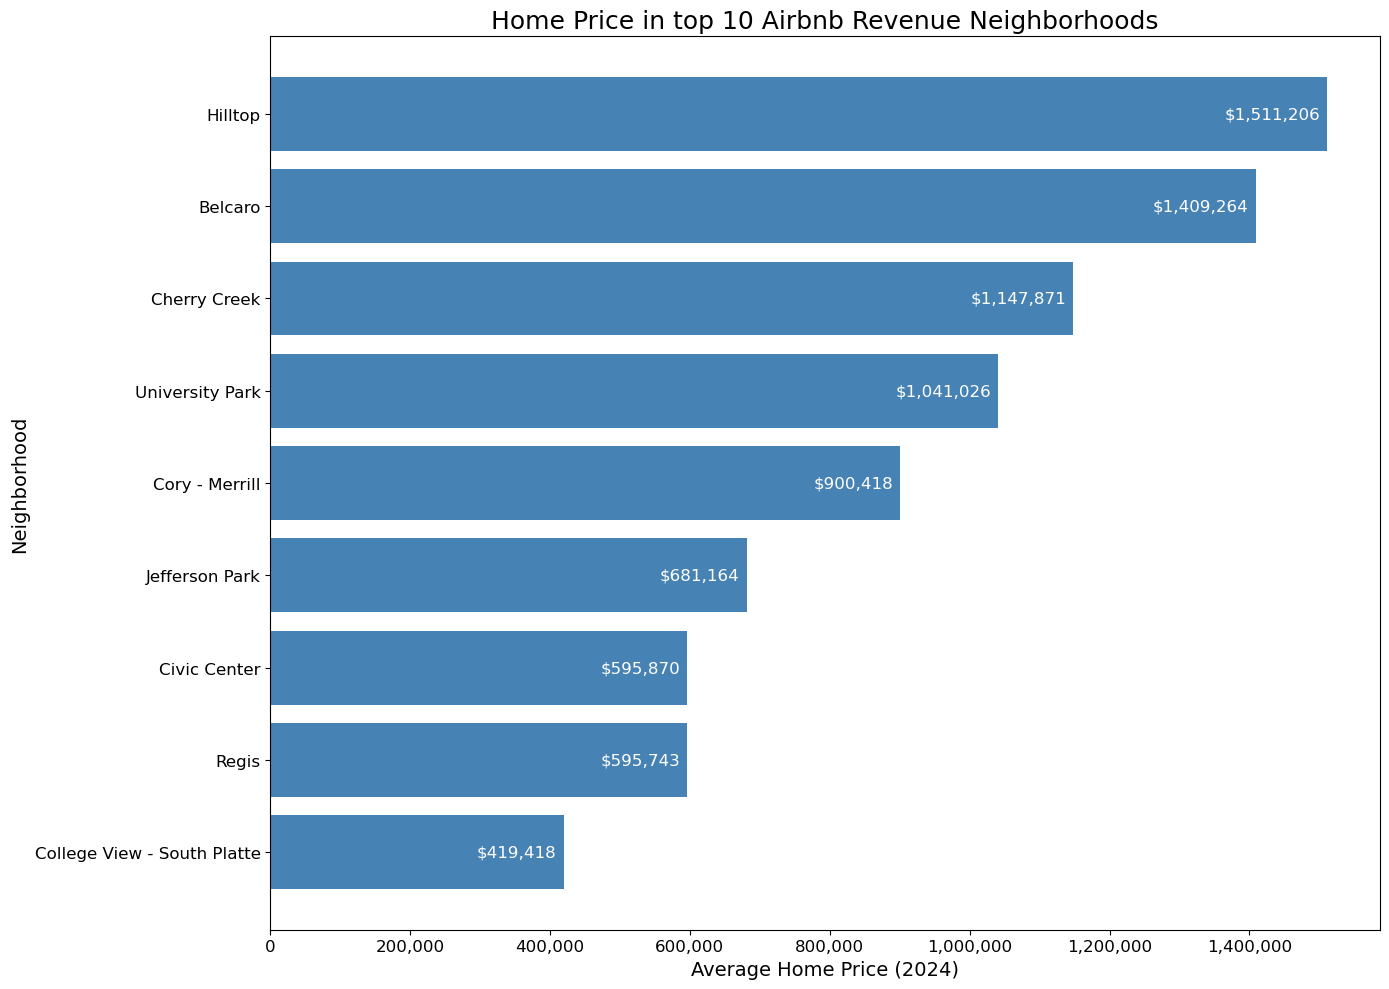

In [ ]:
# Filter Airbnb neighborhoods in the chart image by top revenue 
top_airbnb_chart_neighborhoods = [
    "Belcaro", "University Park", "Jefferson Park", "Regis", "Civic Center",
    "College View - South Platte", "Cherry Creek", "Hilltop", "University Hilld", "Cory - Merrill"
]

# Filter Zillow data to match these neighborhoods
zillow_matched = zillow_df[zillow_df["Neighborhood"].isin(top_airbnb_chart_neighborhoods)]

# Sort by home price for clean plotting
zillow_matched_sorted = zillow_matched.sort_values("Average Home Price 2024", ascending=False)

# Plot
plt.figure(figsize=(14, 10))
plt.barh(zillow_matched_sorted["Neighborhood"], zillow_matched_sorted["Average Home Price 2024"])
plt.xlabel("Average Home Price (2024)", fontsize=14)
plt.ylabel("Neighborhood", fontsize=14)
plt.title("Home Price in top 10 Airbnb Revenue Neighborhoods", fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

bars = ax.barh(zillow_matched["Neighborhood"], zillow_matched["Average Home Price 2024"], color="steelblue")
for bar in bars:
    width = bar.get_width()
    plt.text(width - 10000,  # adjust this number depending on bar length
             bar.get_y() + bar.get_height() / 2,
             f"${width:,.0f}",
             va='center', ha='right', fontsize=12, color='white')




plt.savefig('graphs/home_prices.png')
plt.show()

In [ ]:
print(zillow_df.head())

   RegionID                  Neighborhood  Average Home Price 2024
0  273809.0  Gateway - Green Valley Ranch                489603.54
1    6018.0                     Montbello                438895.80
2  275564.0                  Central Park                805134.55
3  268671.0                       Hampden                523696.84
4  268662.0                   Five Points                612445.71


In [ ]:
# Strip whitespace from all column names (if you haven't already)
zillow_df.columns = zillow_df.columns.str.strip()

# Recalculate 70% occupancy revenue for Airbnb listings
listings_df_cleaned["potential_revenue"] = listings_df_cleaned["Price"] * listings_df_cleaned["Available Days per Year"]
listings_df_cleaned["potential_revenue_70"] = listings_df_cleaned["potential_revenue"] * 0.7

# Group by neighborhood to get average potential revenue at 70% occupancy
airbnb_grouped = listings_df_cleaned.groupby("Neighborhood")["potential_revenue_70"].mean().compute().reset_index()

# Define target neighborhoods
target_neighborhoods = [
    "Belcaro", "University Park", "Jefferson Park", "Regis", "Civic Center",
    "College View - South Platte", "Cherry Creek", "Hilltop", "University Hilld", "Cory - Merrill"
]

# Filter both datasets to matching neighborhoods using pandas
airbnb_filtered_df = airbnb_grouped[airbnb_grouped["Neighborhood"].isin(target_neighborhoods)]
zillow_filtered_df = zillow_df[zillow_df["Neighborhood"].isin(target_neighborhoods)]

# Merge the data (Airbnb revenue + Zillow home prices)
combined_df = dd.merge(
    airbnb_filtered_df,
    zillow_filtered_df[["Neighborhood", "Average Home Price 2024"]],
    on="Neighborhood", how = "inner"
)

# Sort by potential Airbnb revenue (70% occupancy)
combined_df = combined_df.compute().sort_values("potential_revenue_70", ascending=False)

# Display the result
combined_df.head()


,Neighborhood,potential_revenue_70,Average Home Price 2024
0,Belcaro,57912.400000,1409263.58
8,University Park,56391.545000,1041026.24
6,Jefferson Park,52153.297938,681163.62
7,Regis,51416.166667,595743.24
2,Civic Center,43796.077500,595870.12


In [ ]:
# Housing cost annualy assuming 36 mo lease
combined_df["Annual housing cost"] = (combined_df["Average Home Price 2024"] / 30).round(2)
combined_df

,Neighborhood,potential_revenue_70,Average Home Price 2024,Annual housing cost
0,Belcaro,57912.400000,1409263.58,46975.45
8,University Park,56391.545000,1041026.24,34700.87
6,Jefferson Park,52153.297938,681163.62,22705.45
7,Regis,51416.166667,595743.24,19858.11
2,Civic Center,43796.077500,595870.12,19862.34
3,College View - South Platte,43657.512500,419418.07,13980.60
1,Cherry Creek,36972.350000,1147870.68,38262.36
5,Hilltop,36712.153333,1511205.69,50373.52
4,Cory - Merrill,35440.922222,900417.92,30013.93


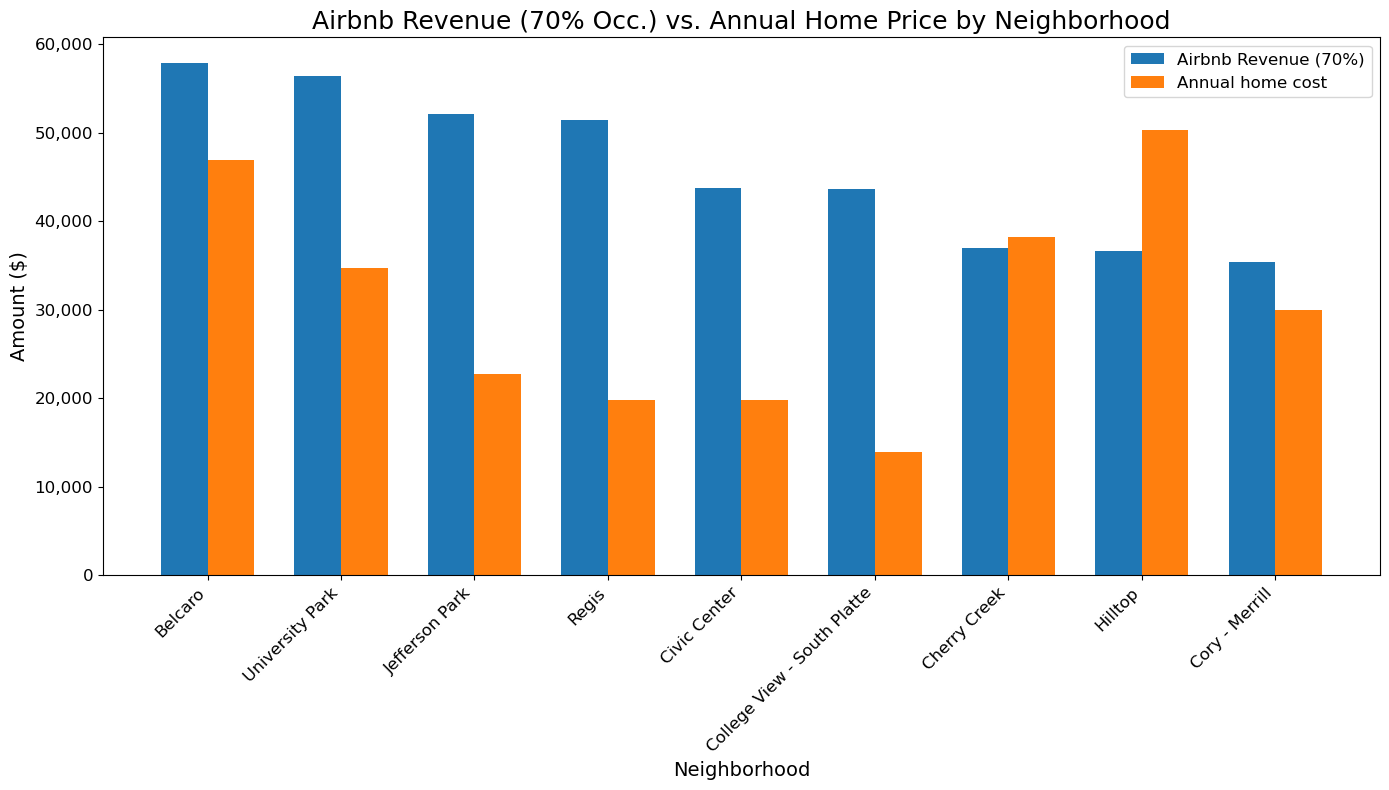

In [ ]:
x = np.arange(len(combined_df))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))

bar1 = ax.bar(x - width/2, combined_df["potential_revenue_70"], width, label="Airbnb Revenue (70%)")
bar2 = ax.bar(x + width/2, combined_df["Annual housing cost"], width, label="Annual home cost")

ax.set_xlabel("Neighborhood", fontsize=14)
ax.set_ylabel("Amount ($)", fontsize=14)
ax.set_title("Airbnb Revenue (70% Occ.) vs. Annual Home Price by Neighborhood", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(combined_df["Neighborhood"], rotation=45, ha='right', fontsize=12)
ax.legend(fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


plt.tight_layout()

plt.savefig('graphs/revenue_v_home_price.png')
plt.show()